In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import umap

import pandas as pd
from scipy.spatial import cKDTree

HSC_color = 'grey'
HSC_TNG50_color = 'bisque'
HSC_TNG100_color = 'aqua'
TNG50_color = 'orange'
TNG100_color = 'blue'

In [2]:
df = pd.read_csv('../../dataset/m_test.csv')

df["petro_90_light"] = df['petro_90_light'].multiply(0.168)

print(df.columns.values)

['object_id' 'photoz' 'petroR90_r' 'r_cmodel_mag_ge' 'g_cmodel_mag_ge'
 'i_cmodel_mag_ge' 'z_cmodel_mag_ge' 'image_path' 'petro_half_light'
 'petro_90_light' 'dataset' 'matched_set' 'root_descendant_id' 'lookback'
 'z' 'stellar_age_2rhalf_lumw' 'fraction_disk_stars' 'stellar_mass'
 'mass_in_rad' 'half_mass_rad_physical' 'color' 'i_band_mag_dust_apparent'
 'asymmetry' 'concentration' 'deviation' 'gini_m20_bulge'
 'gini_m20_merger' 'sersic_n' 'sersic_rhalf' 'sersic_ellip' 'smoothness'
 'snapshot_id' 'subhalo_id' 'projection' 'mass']


In [3]:
import pandas as pd
from sklearn.utils import shuffle

#Set seed
SEED = 0

#Plot a single UMAP of x with color c
def create_umap(x, n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean'):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        densmap=False,
        random_state=SEED
    )
    u = fit.fit_transform(x);
    
    return np.array(u)

with open('../../postprocessing/representation.npy', 'rb') as f:
    rep = np.load(f)
        

n_neighbors = [10, 50, 100]
min_dist = [0.1, 0.5, 1]

for n in n_neighbors:
    for dist in min_dist:
        try:
            u = create_umap(rep, n_neighbors=n, min_dist=dist)
            d = {'u_0': u[:,0], 'u_1': u[:,1], 'dataset': df['dataset']}
            plt.title('n_neighbors = ' + str(n) + ' ' + 'min_dist = ' + str(dist))
            sns.kdeplot(data=pd.DataFrame(d), x='u_0', y='u_1', hue="dataset")
            plt.show()
        except:
            print('n_neighbors = ' + str(n) + ' ' + 'min_dist = ' + str(dist) + ' failed!')

In [4]:
u = create_umap(rep, n_neighbors=100, min_dist=0.5)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


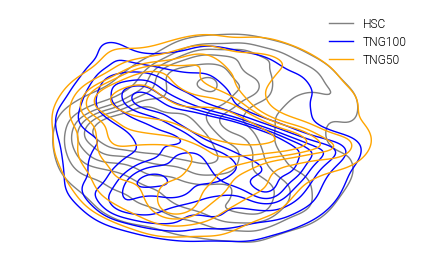

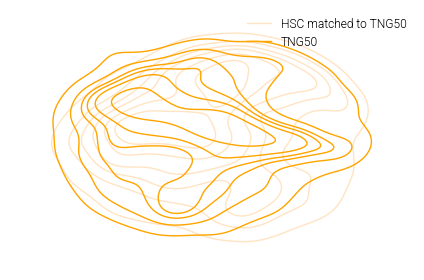

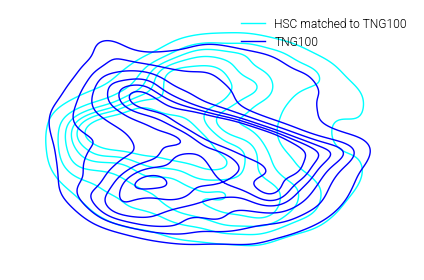

In [5]:
palette = {'HSC matched to TNG50': HSC_TNG50_color,
           'HSC matched to TNG100': HSC_TNG100_color,
           'TNG50': TNG50_color,
           'TNG100': TNG100_color,
           'HSC': HSC_color}

matched_set = df['matched_set'].to_numpy()
dataset = df['dataset'].to_numpy()
dataset[dataset=='HSC_TNG100'] = 'TNG100'
dataset[dataset=='HSC_TNG50'] = 'TNG50'
d = {'u_0': u[:,0], 'u_1': u[:,1], 'Dataset': dataset}
d = pd.DataFrame(d)

#TNG vs all HSC
g = sns.kdeplot(data=d, x='u_0', y='u_1', hue="Dataset", palette=palette, common_norm=False, levels = 7)
g.get_legend().set_title(None)
ax = plt.gca()
ax.axis('off')
g.get_figure().savefig("../../temp/kde.pdf") 
plt.show()

#Seperate the two splits of HSC
dataset[np.logical_and(dataset=='HSC', matched_set=='HSC_TNG50')] = 'HSC matched to TNG50'
dataset[np.logical_and(dataset=='HSC', matched_set=='HSC_TNG100')] = 'HSC matched to TNG100'
d = {'u_0': u[:,0], 'u_1': u[:,1], 'Dataset': dataset}
d = pd.DataFrame(d)

#Plot separate for TNG50 and TNG100
d_TNG50 = d[np.logical_or(d['Dataset'] == 'HSC matched to TNG50', d['Dataset'] == 'TNG50')]
d_TNG100 = d[np.logical_or(d['Dataset'] == 'HSC matched to TNG100', d['Dataset'] == 'TNG100')]

g = sns.kdeplot(data=d_TNG50, x='u_0', y='u_1', hue="Dataset", palette=palette, common_norm=False, levels = 7)
g.get_legend().set_title(None)
ax = plt.gca()
ax.axis('off')
g.get_figure().savefig("../../temp/kde_TNG50.pdf") 
plt.show()

g = sns.kdeplot(data=d_TNG100, x='u_0', y='u_1', hue="Dataset", palette=palette, common_norm=False, levels = 7)
g.get_legend().set_title(None)
ax = plt.gca()
ax.axis('off')
g.get_figure().savefig("../../temp/kde_TNG100.pdf") 
plt.show()

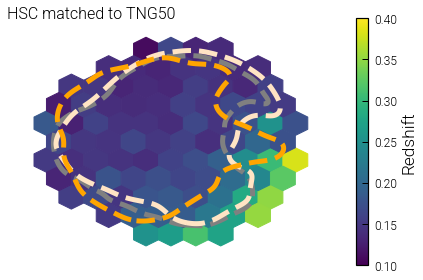

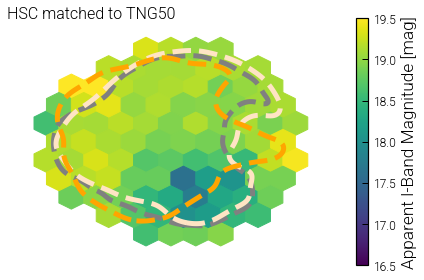

KeyboardInterrupt: 

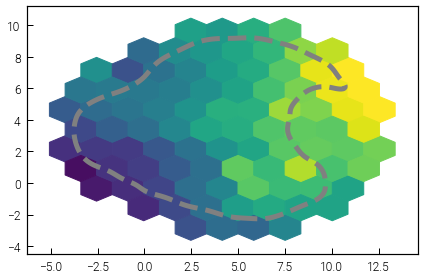

In [9]:
#Prepare masks
TNG100_mask = dataset == 'TNG100'
TNG50_mask = dataset == 'TNG50'
HSC_mask = np.logical_or(dataset == 'HSC matched to TNG50', dataset == 'HSC matched to TNG100')
HSC_TNG50_mask = dataset == 'HSC matched to TNG50'
HSC_TNG100_mask = dataset == 'HSC matched to TNG100'

#Prepare the data for the plotting
vmin = {'photoz':0.1, 'i_cmodel_mag_ge':16.5, 'petro_90_light':10*0.168, 'z':0.1, 'i_band_mag_dust_apparent':16.5}
vmax = {'photoz':0.4, 'i_cmodel_mag_ge':19.5, 'petro_90_light':35*0.168, 'z':0.4, 'i_band_mag_dust_apparent':19.5}
gridsize = {'HSC': 20, 'HSC_TNG50': 10, 'HSC_TNG100':20, 'TNG100': 20, 'TNG50': 10}
mask_dict = {'HSC': HSC_mask, 'HSC_TNG50':HSC_TNG50_mask, 'HSC_TNG100':HSC_TNG100_mask, 'TNG100': TNG100_mask, 'TNG50': TNG50_mask}
kde_dict = {'HSC_TNG50': ['HSC', 'HSC_TNG50', 'TNG50'],
            'HSC_TNG100': ['HSC', 'HSC_TNG100', 'TNG100'],
            'TNG50': ['HSC', 'HSC_TNG50', 'TNG50'],
            'TNG100': ['HSC', 'HSC_TNG100', 'TNG100']}
palette = {'HSC_TNG50': HSC_TNG50_color,
           'HSC_TNG100': HSC_TNG100_color,
           'TNG50': TNG50_color,
           'TNG100': TNG100_color,
           'HSC': HSC_color}
dataset_human_dict =  {'HSC_TNG50': 'HSC matched to TNG50',
                       'HSC_TNG100': 'HSC matched to TNG100',
                       'TNG50': 'TNG50',
                       'TNG100': 'TNG100',
                       'HSC': 'HSC'}
label_human_dict = {'photoz': 'Redshift',
                    'z': 'Redshift',
                    'i_cmodel_mag_ge': 'Apparent I-Band Magnitude [mag]',
                    'i_band_mag_dust_apparent': 'Apparent I-Band Magnitude [mag]',
                    'petro_90_light': 'Petrosian $90 \%$ radius [arcsec]'}

dataset_list = ['HSC_TNG50', 'TNG50', 'HSC_TNG100', 'TNG100']
label_list = ['photoz', 'z','i_band_mag_dust_apparent', 'i_cmodel_mag_ge', 'petro_90_light']

for d in dataset_list:
    for label in label_list:
        
        mask = mask_dict[d]
        C = df[label][mask]
        
        if sum(C.notna()) == 0:
            continue
        
        plt.hexbin(u[mask,0],u[mask,1],
                   C=C,
                   gridsize=gridsize[d],
                   mincnt=5,
                   reduce_C_function=np.median,
                   vmin = vmin[label], 
                   vmax = vmax[label])

    
        #Print kde
        for kde_d in kde_dict[d]:
            mask = mask_dict[kde_d]
            sns.kdeplot(x=u[mask,0], y=u[mask,1], levels=[0.2], linewidths=5, linestyles='dashed', color=palette[kde_d])
        
        plt.colorbar(label=label_human_dict[label])
        ax = plt.gca()
        ax.axis('off')
        plt.text(0, 1, dataset_human_dict[d], color='k', size=16, transform=ax.transAxes)
        plt.savefig('../../temp/umap_compare_' + d + '_' + label + '.pdf')
        plt.show()
        

Fraction of Disk Stars
25896
0


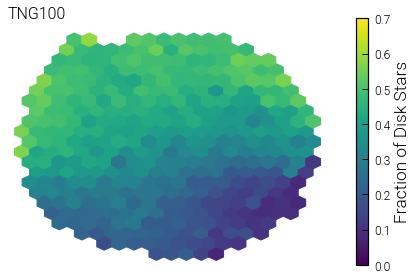

g-r Color [mag]
25896
0


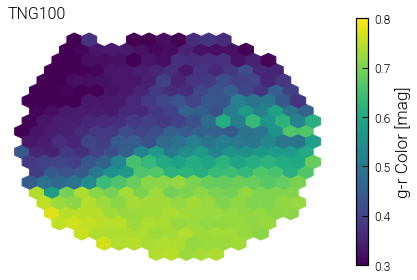

Stellar Mass [$M_\odot$]
25896
0


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


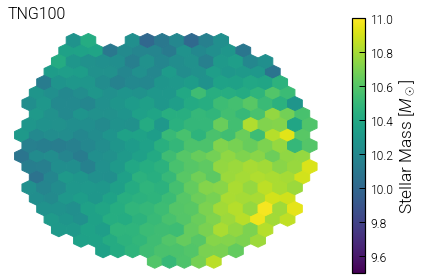

Half Mass Radius [kpc]
25896
0


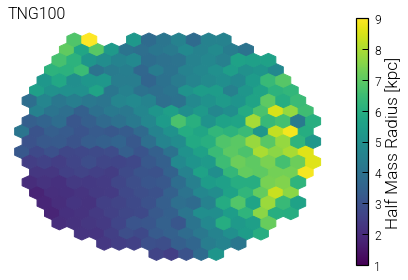

Asymmetry
25896
4352


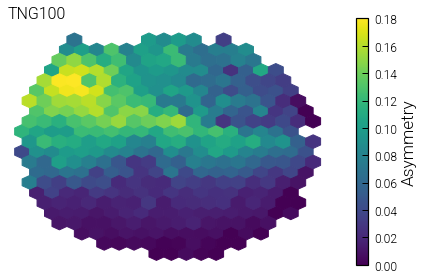

Concentration
25896
4352


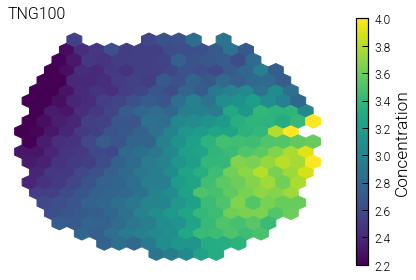

Smoothness
25896
4352


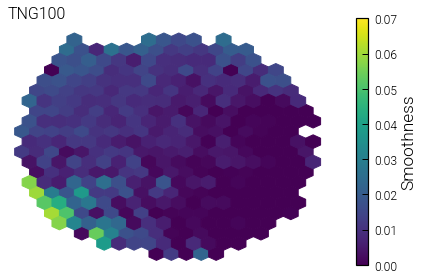

Sersic N
25896
4352


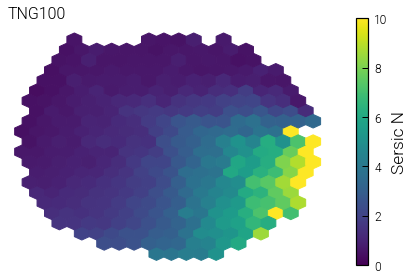

Sersic Rhalf
25896
4352


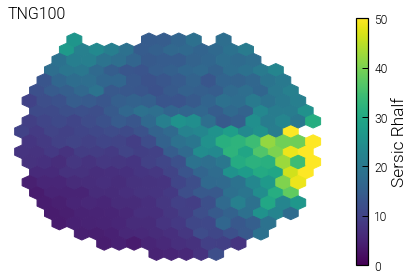

Sersic Ellip
25896
4352


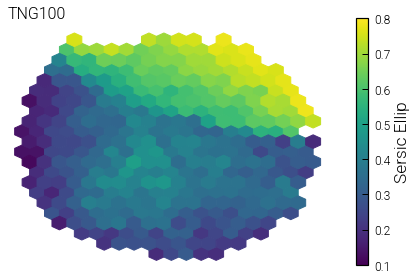

Gini-M20 Bulge
25896
4352


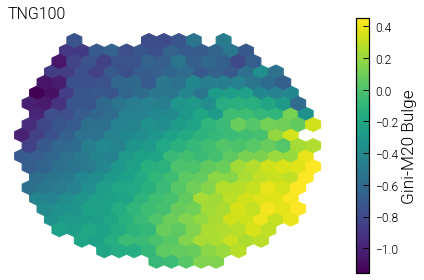

Gini-M20 Merger
25896
4352


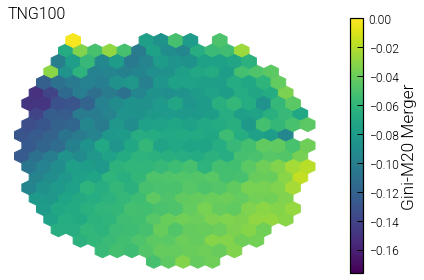

Fraction of Disk Stars
5721
0


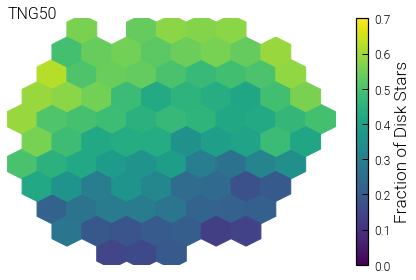

g-r Color [mag]
5721
0


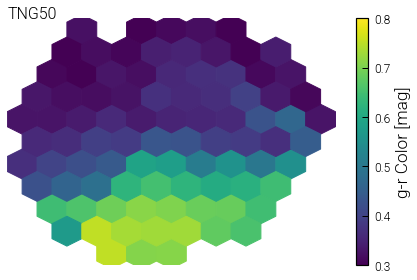

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


Stellar Mass [$M_\odot$]
5721
0


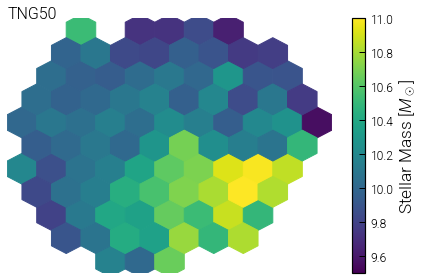

Half Mass Radius [kpc]
5721
0


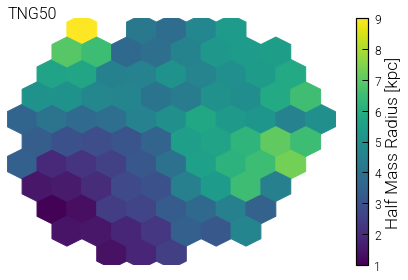

Asymmetry
5721
75


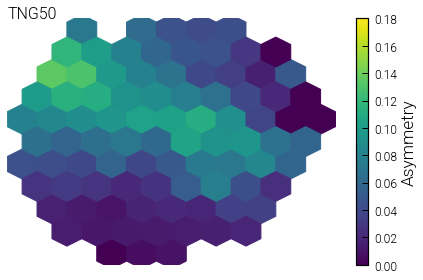

Concentration
5721
75


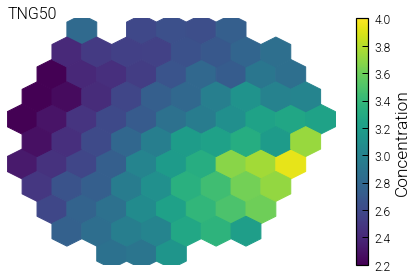

Smoothness
5721
75


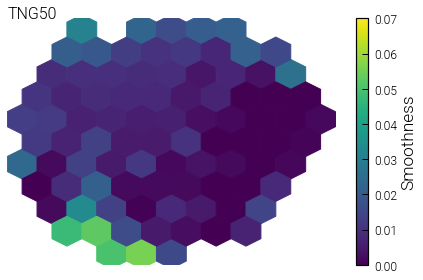

Sersic N
5721
75


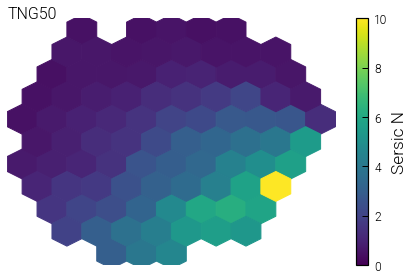

Sersic Rhalf
5721
75


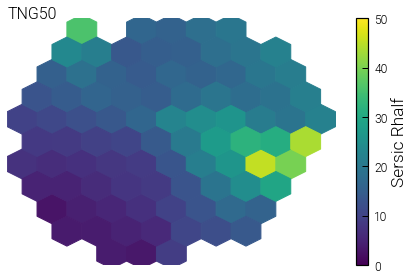

Sersic Ellip
5721
75


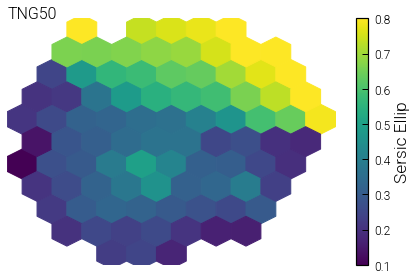

Gini-M20 Bulge
5721
75


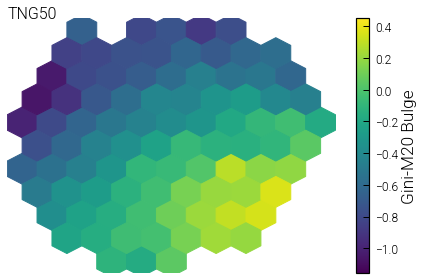

Gini-M20 Merger
5721
75


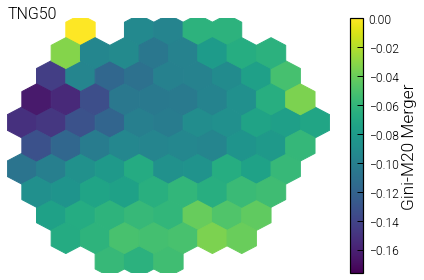

In [11]:
label_TNG =['fraction_disk_stars', 'color',  'mass', 'half_mass_rad_physical', 'asymmetry', 'concentration', 'smoothness', 'sersic_n', 'sersic_rhalf', 'sersic_ellip', 'gini_m20_bulge', 'gini_m20_merger']
label_TNG_human =['Fraction of Disk Stars', 'g-r Color [mag]', 'Stellar Mass [$M_\odot$]', 'Half Mass Radius [kpc]', 'Asymmetry', 'Concentration', 'Smoothness', 'Sersic N', 'Sersic Rhalf', 'Sersic Ellip', 'Gini-M20 Bulge', 'Gini-M20 Merger']
vmin_list = [0.0,0.3,9.5,1.,0,2.2,0,0,0,0.1,0.45,0]
vmax_list = [0.7,0.8,11.,9.,0.18,4,0.07,10,50,0.8,-1.05,-0.16]

for TNG_mask, l, gridsize in zip([TNG100_mask, TNG50_mask], ['TNG100', 'TNG50'], [20, 10]):
    for label, label_h, vmin, vmax in zip(label_TNG, label_TNG_human, vmin_list, vmax_list):
        print(label_h)
        print(len(df[label][TNG_mask]))
        print(np.isnan(df[label][TNG_mask]).sum())
        plt.hexbin(u[TNG_mask,0],u[TNG_mask,1],C=df[label][TNG_mask], gridsize=gridsize, mincnt=5, reduce_C_function=np.median, vmin=vmin, vmax=vmax)
        plt.colorbar(label=label_h)
        ax = plt.gca()
        ax.axis('off')
        plt.text(0, 1, l, color='k', size=16, transform=ax.transAxes)
        plt.savefig(f'../../temp/{l}_{label}.pdf')
        plt.show()

In [6]:
NUM_IMAGES_PER_SIDE = 24

u0 = np.linspace(np.min(u[:,0]), np.max(u[:,0]), num=NUM_IMAGES_PER_SIDE)
u1 = np.linspace(np.min(u[:,1]), np.max(u[:,1]), num=NUM_IMAGES_PER_SIDE)

u0v, u1v = np.meshgrid(u0, u1)

In [7]:
def get_filenames(mask):
    tree = cKDTree(u[mask,:], compact_nodes=False, balanced_tree=False)
    image_paths = df['image_path'][mask].to_numpy()

    filenames = np.empty_like(u0v, dtype=object)
    MAX_DISTANCE = 0.2

    for i in range(NUM_IMAGES_PER_SIDE):
        for j in range(NUM_IMAGES_PER_SIDE):
            distance, index = tree.query([u0v[i,j], u1v[i,j]], k=[1], p=1, workers=-1)

            if distance < MAX_DISTANCE:
                filenames[i,j] = "../." + image_paths[index][0]
            else:
                filenames[i,j] = ""
                
    return filenames
        
HSC_filenames = get_filenames(np.logical_or(df['dataset'] == 'HSC matched to TNG50', df['dataset'] == 'HSC matched to TNG100'))
TNG100_filenames = get_filenames(df['dataset'] == 'TNG100')
TNG50_filenames = get_filenames(df['dataset'] == 'TNG50')

/u/leisert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


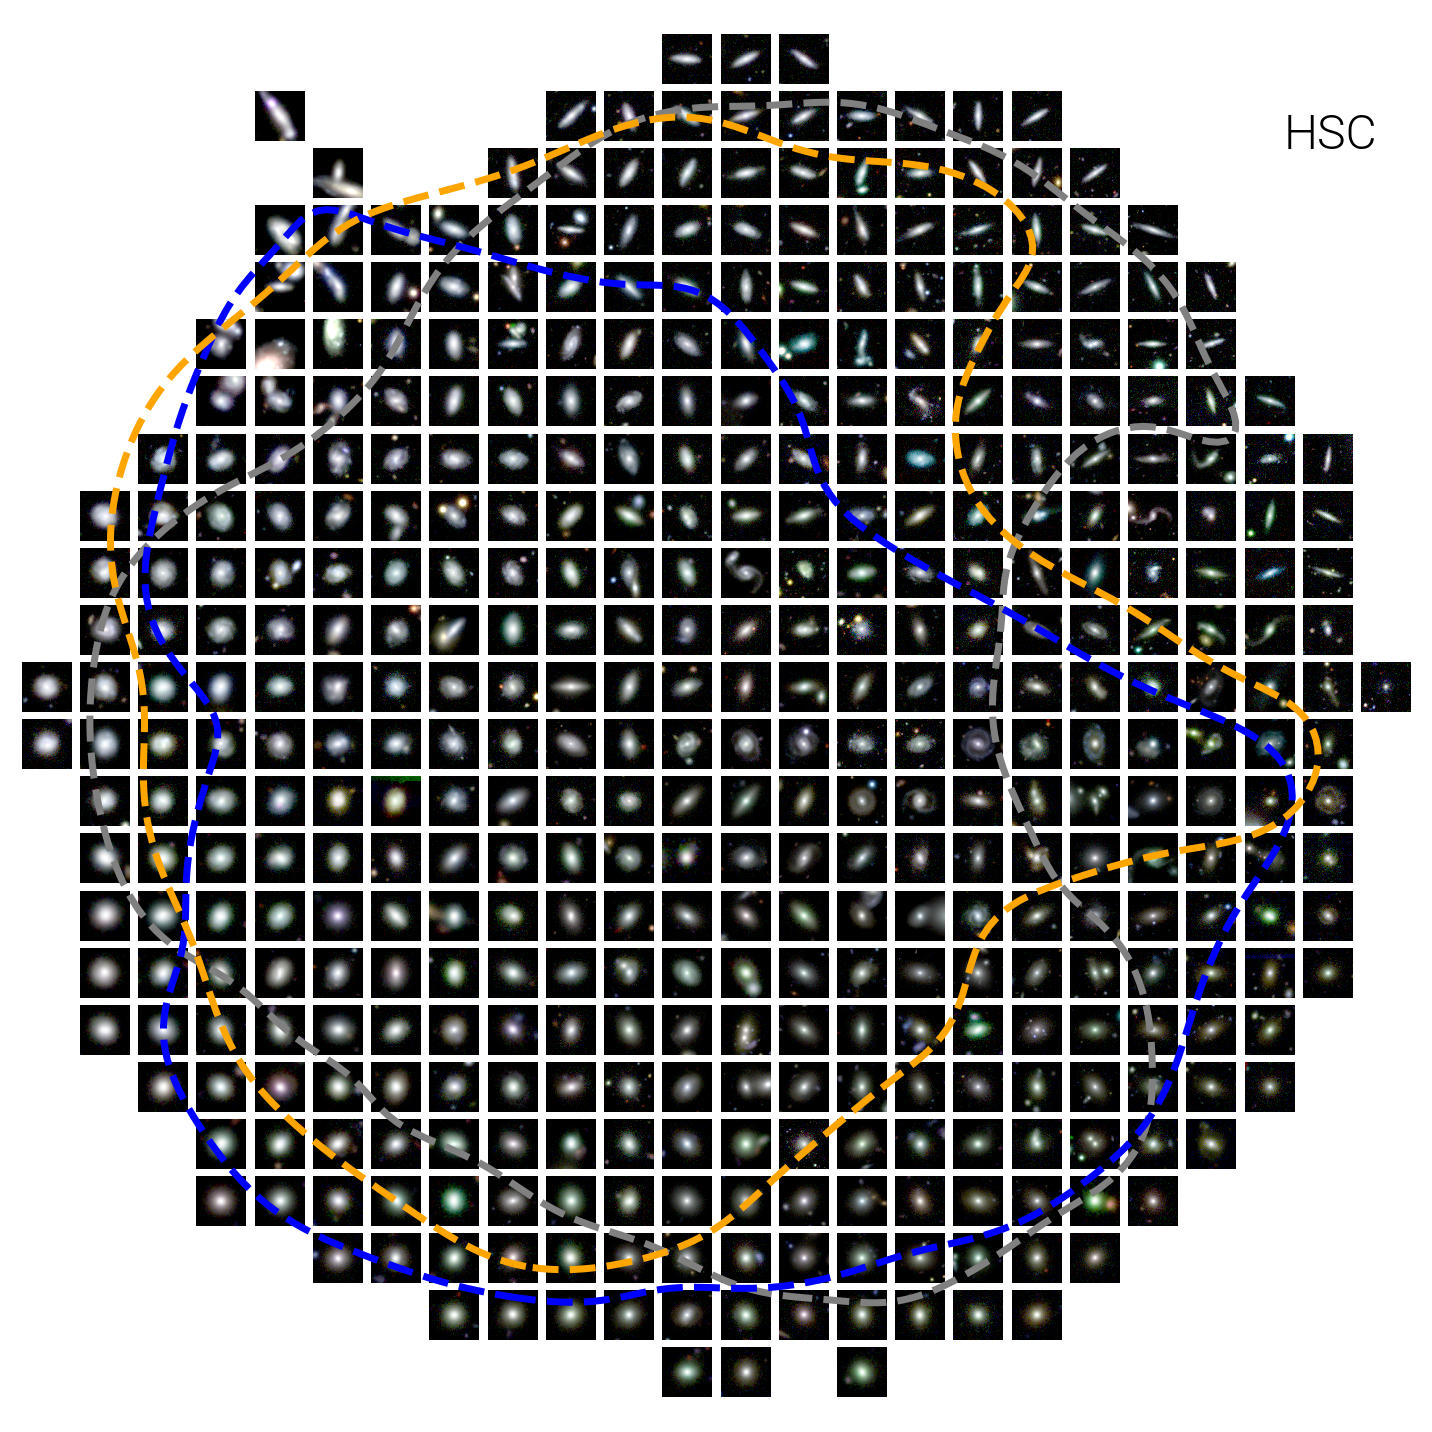

/u/leisert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


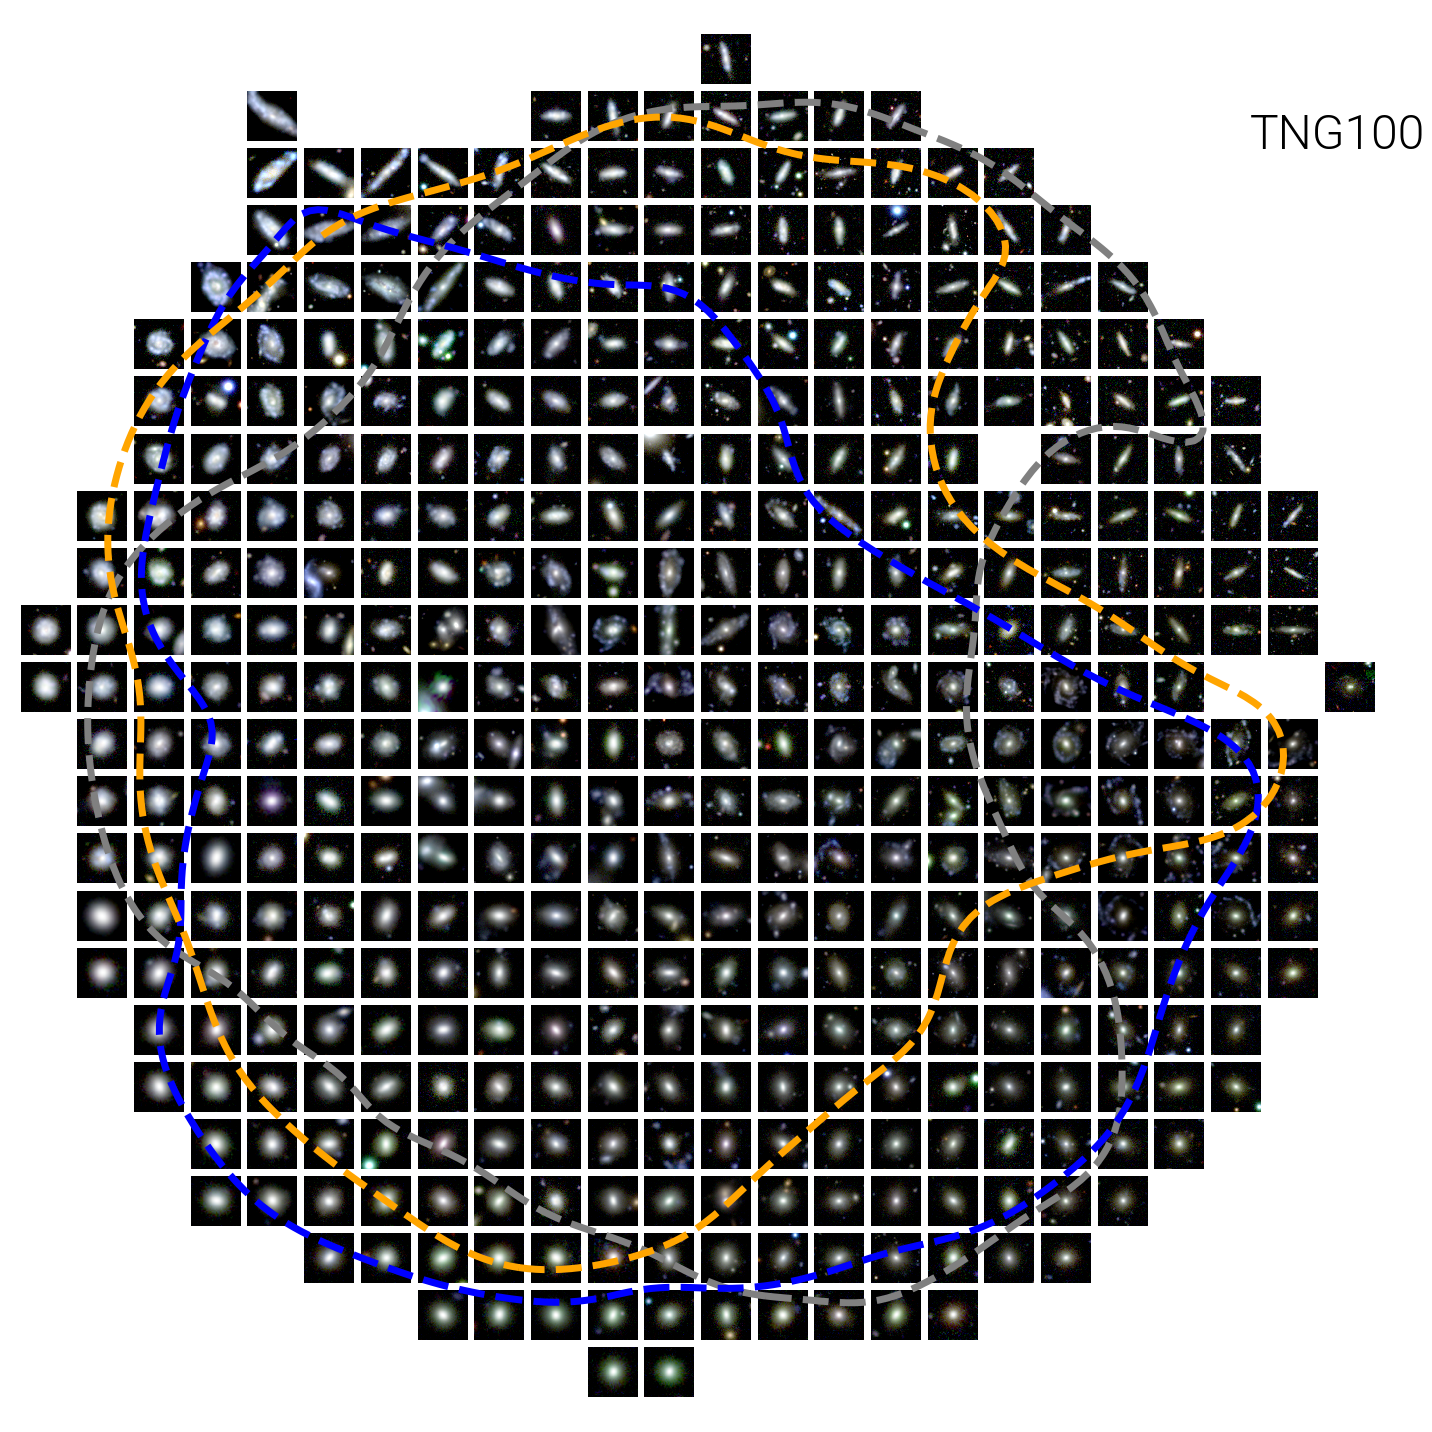

/u/leisert/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


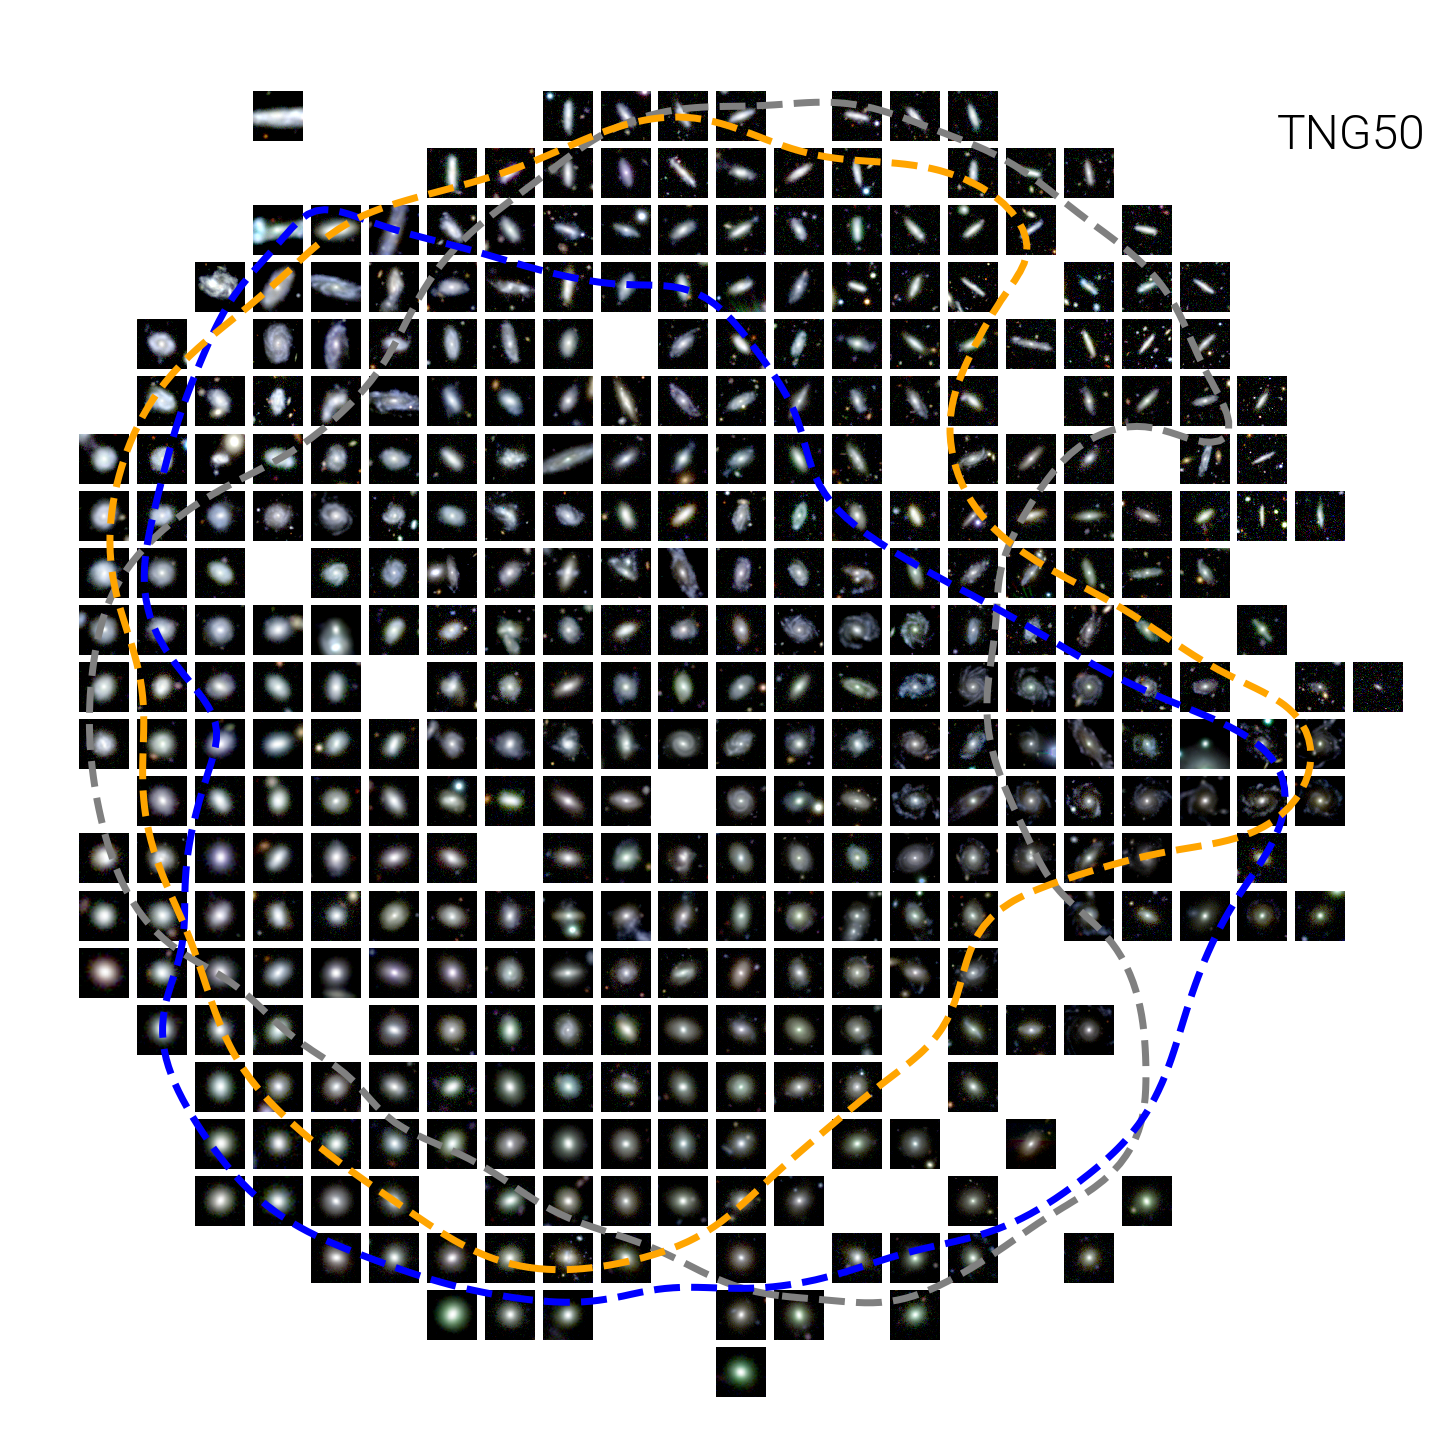

In [10]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import numpy as np
from astropy.io import fits

def load_image(filename):
    
    def get_central_crop(img, num_pixel=20):
        size = img.shape[0]
        center_coordinate = size//2
        upper = center_coordinate + num_pixel//2
        lower = center_coordinate - num_pixel//2
    
        return img[lower:upper, lower:upper]
    
    def stretch(x):
        x[x<=0] = np.nan
        x = np.log10(x)
        x[x<-7] = np.nan
        
        a_min = np.nanmedian(x)
        a_max = np.nanquantile(get_central_crop(x), 0.99)
        
        x = np.nan_to_num(x, nan=a_min, posinf=a_min, neginf=a_min)
        x = np.clip(x, a_min, a_max)
        
        x -= a_min
        x /= (a_max - a_min)
        
        return np.array(x*(2**8 - 1), dtype=np.uint8)
    
    with fits.open(filename) as hdul:
            
        G = hdul['G'].data
        R = hdul['R'].data
        I = hdul['I'].data
            
    G = stretch(G)
    R = stretch(R)
    I = stretch(I)

    return np.concatenate((I[...,np.newaxis],R[...,np.newaxis],G[...,np.newaxis]),axis=2)


for filenames, title in zip([HSC_filenames, TNG100_filenames, TNG50_filenames], ("HSC", "TNG100", 'TNG50')):
    
    fig, ax = plt.subplots(figsize=(20., 20.))

    PADDING = 0.5
    ax.set_xlim(u0[0]-PADDING, u0[-1]+PADDING)
    ax.set_ylim(u1[0]-PADDING, u1[-1]+PADDING)
    
    for i in range(NUM_IMAGES_PER_SIDE):
        for j in range(NUM_IMAGES_PER_SIDE):
            u0d = u0v[i,j]
            u1d = u1v[i,j]
            filename = filenames[i,j]

            if filename != "":
                im = load_image(filename)
                TARGET_IMAGE_SIZE = 50
                zoom_factor = TARGET_IMAGE_SIZE/im.shape[0]

                imagebox = OffsetImage(im, zoom=zoom_factor)
                ab = AnnotationBbox(imagebox, (u0d, u1d), frameon=False)
                ab.set_zorder(0)
                ax.add_artist(ab)
                ax.axis('off')
                
    sns.kdeplot(x=u[HSC_mask,0], y=u[HSC_mask,1], levels=[0.2], linewidths=7, color=palette['HSC'], linestyles='dashed')
    sns.kdeplot(x=u[TNG100_mask,0], y=u[TNG100_mask,1], levels=[0.2], linewidths=7, color=palette['TNG100'], linestyles='dashed')
    sns.kdeplot(x=u[TNG50_mask,0], y=u[TNG50_mask,1], levels=[0.2], linewidths=7, color=palette['TNG50'], linestyles='dashed')
    plt.text(0.9, 0.9, title, color='k', size=48, transform=ax.transAxes)
    plt.savefig('../../temp/images_' + title + '.pdf')
    plt.show()